


## Ответы на вопросы: 
1. Могу сказать, что есть калькуляторы, которые подбирают подходящий размер выборки, в которые мы вбиваем желаемые параметры. Обычно это ожидаемый размер эффекта, статистическую мощность теста (обычно 80-90%), уровень значимости (часто 5%), а также предварительные оценки метрик для каждой группы. 
2. В бриф эксперимента должны входить: четкое описание целей теста, гипотезы, описание контрольной и экспериментальной групп, параметры тестирования, критерии успеха, методы сбора и анализа данных. Должны также учесть различные промо, чтобы они не помешали эксперименту и прочие влияние из вне (например, праздники). На мой взгляд, самое важное, это понимание, к чему мы хотим прийти и какой вывод получить. 
3. Определяем метрики на основании целей теста. Они должны быть достаточно чувствительными к изменениям, то есть глоабльные метрики компании не подходят. Если говорить более конкретно, то метрики должны быть релевантными, точными, и консистентными. Основная их цель показать влияние эксперимента. Помимо этого к качеству метрики можно отнести терпимость к внешним событиям и стабильность. 

## Проверка данных

Постараемся проверить данные на всё возможное:
    - выбросы
    -пропуски 
    -консистентность 
    
Посмотрим распределение


In [3]:
import pandas as pd


orders_df = pd.read_csv('/Users/ekolodyazhnaya/Downloads/orders.csv')
visitors_df = pd.read_csv('/Users/ekolodyazhnaya/Downloads/visitors.csv')


orders_df.head(), visitors_df.head()

(   transactionId   visitorId        date  revenue group
 0     3667963787  3312258926  2019-08-15     1650     B
 1     2804400009  3642806036  2019-08-15      730     B
 2     2961555356  4069496402  2019-08-15      400     A
 3     3797467345  1196621759  2019-08-15     9759     B
 4     2282983706  2322279887  2019-08-15     2308     B,
          date group  visitors
 0  2019-08-01     A       719
 1  2019-08-02     A       619
 2  2019-08-03     A       507
 3  2019-08-04     A       717
 4  2019-08-05     A       756)

In [5]:
# проверим посетителей на попадание в обе группы 
cross_group_visitors = orders_df.groupby('visitorId').agg({'group': 'nunique'}).query('group > 1')
cross_group_visitors_count = cross_group_visitors.shape[0]
cross_group_visitors_count
# они у нас есть и мы их исключаем из анализа 

cross_group_visitor_ids = cross_group_visitors.index
filtered_orders_df = orders_df[~orders_df['visitorId'].isin(cross_group_visitor_ids)]

In [28]:
filtered_orders_df

,transactionId,visitorId,date,revenue,group,capped_revenue,conversion_count,hour_of_day,day_of_week,month
0,3667963787,3312258926,2019-08-15,1650,B,1650,1,0,3,8
1,2804400009,3642806036,2019-08-15,730,B,730,1,0,3,8
3,3797467345,1196621759,2019-08-15,9759,B,9759,1,0,3,8
4,2282983706,2322279887,2019-08-15,2308,B,2308,1,0,3,8
5,182168103,935554773,2019-08-15,2210,B,2210,1,0,3,8
...,...,...,...,...,...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B,16490,1,0,2,8
1192,2662137336,3733762160,2019-08-14,6490,B,6490,1,0,2,8
1193,2203539145,370388673,2019-08-14,3190,A,3190,1,0,2,8
1194,1807773912,573423106,2019-08-14,10550,A,10550,1,0,2,8


In [ ]:
# посчитаем базовые показатели 

In [6]:

grouped_orders = filtered_orders_df.groupby('group').agg({
    'transactionId': 'count',  
    'revenue': 'sum'    
}).rename(columns={'transactionId': 'conversions'})

total_visitors = visitors_df.groupby('group')['visitors'].sum()


ab_summary = grouped_orders.join(total_visitors)
ab_summary['conversion_rate'] = ab_summary['conversions'] / ab_summary['visitors']

ab_summary


,conversions,revenue,visitors,conversion_rate
group,,,,
A,468,3364656,18736,0.024979
B,548,5068972,18916,0.028970


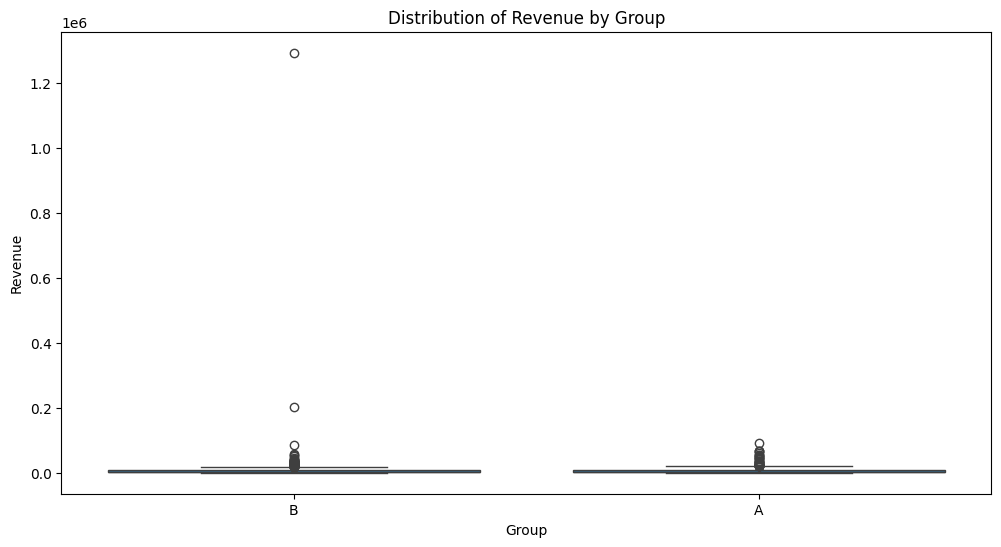

(count    1.016000e+03
 mean     8.300815e+03
 std      4.212199e+04
 min      5.000000e+01
 25%      1.190000e+03
 50%      2.955000e+03
 75%      8.134250e+03
 max      1.294500e+06
 Name: revenue, dtype: float64,
 transactionId    0
 visitorId        0
 date             0
 revenue          0
 group            0
 dtype: int64,
 date        0
 group       0
 visitors    0
 dtype: int64)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


null_values_orders = filtered_orders_df.isnull().sum()
null_values_visitors = visitors_df.isnull().sum()


revenue_descriptive_stats = filtered_orders_df['revenue'].describe()


plt.figure(figsize=(12, 6))
sns.boxplot(x=filtered_orders_df['group'], y=filtered_orders_df['revenue'])
plt.title('Distribution of Revenue by Group')
plt.ylabel('Revenue')
plt.xlabel('Group')
plt.show()

revenue_descriptive_stats, null_values_orders, null_values_visitors


In [10]:
# видим большой выброс в группе B 
# нулевых значений нет, хорошо

In [11]:
# уберём выброс и оставим только 95 квантиль 
cap_threshold = filtered_orders_df['revenue'].quantile(0.95)
filtered_orders_df['capped_revenue'] = filtered_orders_df['revenue'].clip(upper=cap_threshold)

# посчитаем AOV и RPV
# считаем их, так как нам важны показатели связанные именно с revenue
grouped_capped_orders = filtered_orders_df.groupby('group').agg({
    'transactionId': 'count',  
    'capped_revenue': 'sum'   
}).rename(columns={'transactionId': 'conversions'})

ab_summary_capped = grouped_capped_orders.join(total_visitors)


ab_summary_capped['aov_capped'] = ab_summary_capped['capped_revenue'] / ab_summary_capped['conversions']
ab_summary_capped['rpv_capped'] = ab_summary_capped['capped_revenue'] / ab_summary_capped['visitors']

ab_summary_capped[['aov_capped', 'rpv_capped']]


/var/folders/1_/4_8srx850yd3f0g5gqqhplsw0000gp/T/ipykernel_82462/2572570404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orders_df['capped_revenue'] = filtered_orders_df['revenue'].clip(upper=cap_threshold)


,aov_capped,rpv_capped
group,,
A,6214.292735,155.224648
B,6052.686131,175.347431


In [12]:
# видим, что группа B хорошо себя показала на выбранной метрике RPV, проверим, 
# насколько это значение статистически значимо


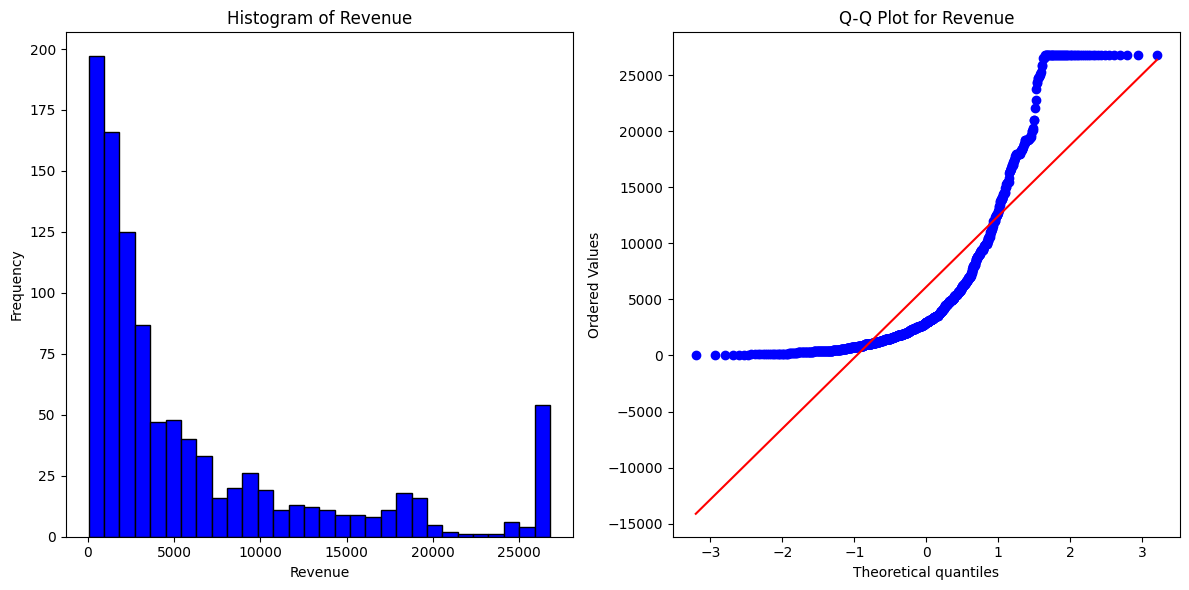

In [31]:
# посмотрим на распределение, подберём способ проверки стат значимости 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# распределение revenue
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(filtered_orders_df['capped_revenue'], bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
stats.probplot(filtered_orders_df['capped_revenue'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Revenue')

plt.tight_layout()
plt.show()


In [32]:
# видим на графиках, что мы не попдаем в нормальное распределение, у нас слишком тяжелые хвосты в revenue. 
# будем использовать два подхода: в первом подходе попробуем нормализовать данные и посмотреть выводы
# во втором подходе, используем непараметрический тест, 
# сравним результаты, сделаем выводы
# стоит указать на то, что я не убираю тут хвосты, так как уже мы немного убрали их
# возможно, для специфики бизнеса это приемлемо. Возможно стоит проводить исследование отдельно для этой группы

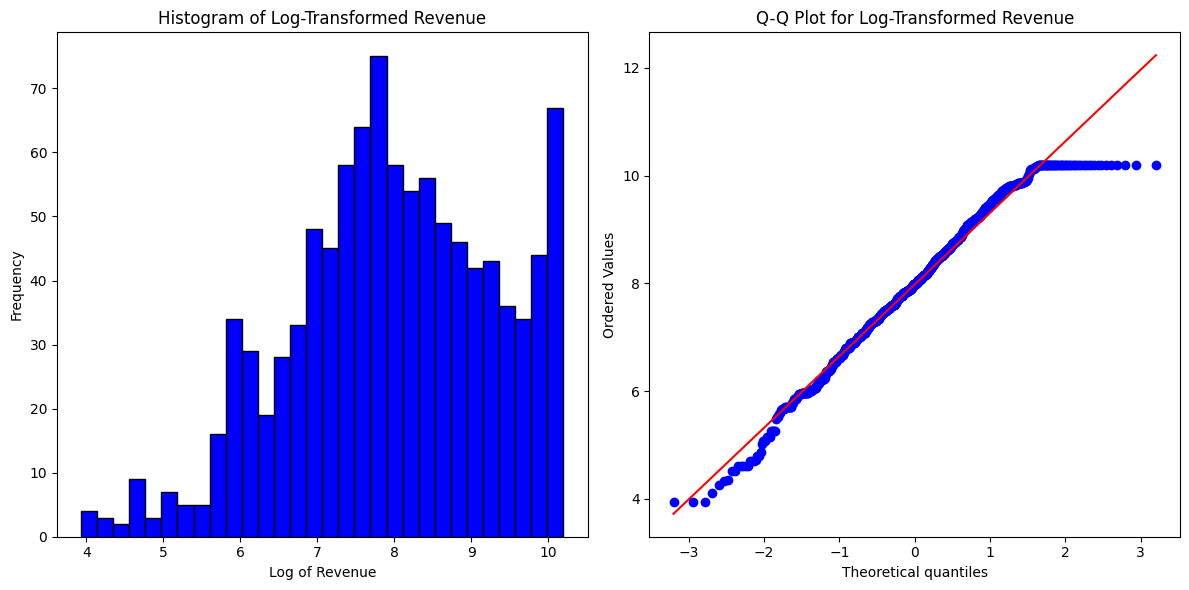

In [33]:
# первый подход 
# логарифмируем данные и проведём затем тест шапиро 
log_revenue = np.log(filtered_orders_df['capped_revenue'] + 1)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(log_revenue, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Log-Transformed Revenue')
plt.xlabel('Log of Revenue')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
stats.probplot(log_revenue, dist="norm", plot=plt)
plt.title('Q-Q Plot for Log-Transformed Revenue')

plt.tight_layout()
plt.show()

In [42]:
# второй заход, проведём сразу несколько тестов: 
# проверим, что распределение нормально
# проведём параметричные и непараметричные проверки
from scipy.stats import shapiro, mannwhitneyu, ttest_ind


cross_group_visitors = orders_df.groupby('visitorId').agg({'group': 'nunique'}).query('group > 1')
cross_group_visitor_ids = cross_group_visitors.index
filtered_orders_df = orders_df[~orders_df['visitorId'].isin(cross_group_visitor_ids)]


grouped_orders = filtered_orders_df.groupby('group').agg({
    'transactionId': 'count',  
    'revenue': 'sum'
}).rename(columns={'transactionId': 'conversions'})

total_visitors = visitors_df.groupby('group')['visitors'].sum()


ab_summary = grouped_orders.join(total_visitors)
ab_summary['conversion_rate'] = ab_summary['conversions'] / ab_summary['visitors']


grouped_capped_orders = filtered_orders_df.groupby('group').agg({
    'transactionId': 'count',  
    'capped_revenue': 'sum'
}).rename(columns={'transactionId': 'conversions'})


group_A = filtered_orders_df[filtered_orders_df['group'] == 'A']
group_B = filtered_orders_df[filtered_orders_df['group'] == 'B']


# Тест на нормальность шапиро
normality_aov_A = shapiro(group_A['capped_revenue'].dropna())
normality_aov_B = shapiro(group_B['capped_revenue'].dropna())

if normality_aov_A.pvalue < 0.05 or normality_aov_B.pvalue < 0.05:
    # непараметричный тест Уитни
    test_result_aov = mannwhitneyu(group_A['capped_revenue'], group_B['capped_revenue'])
else:
    # параметриный t-test
    test_result_aov = ttest_ind(group_A['capped_revenue'], group_B['capped_revenue'])

test_result_aov, normality_aov_A, normality_aov_B


/var/folders/1_/4_8srx850yd3f0g5gqqhplsw0000gp/T/ipykernel_82462/956053699.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_orders_df['capped_revenue'] = filtered_orders_df['revenue'].clip(upper=cap_threshold)


(MannwhitneyuResult(statistic=129145.5, pvalue=0.8447293420488318),
 ShapiroResult(statistic=0.7670460939407349, pvalue=3.173792279020455e-25),
 ShapiroResult(statistic=0.7392160892486572, pvalue=1.9308296305363785e-28))

In [ ]:
# Показатели везде высокие, значит, что добавленное уведомление не получило статистического подтверждения своей успешности.
# Более подробное объяснение будет ниже. 

In [39]:
# проверим конверсию 
from scipy.stats import chi2_contingency

conversion_table = [
    [ab_summary_capped.loc['A', 'conversions'], ab_summary_capped.loc['A', 'visitors'] - ab_summary_capped.loc['A', 'conversions']],
    [ab_summary_capped.loc['B', 'conversions'], ab_summary_capped.loc['B', 'visitors'] - ab_summary_capped.loc['B', 'conversions']]
]


chi2, p_value, _, _ = chi2_contingency(conversion_table)

chi2, p_value

(5.560773535163217, 0.018367296895696848)

In [51]:

from statsmodels.stats.proportion import proportions_ztest

conversions_A = ab_summary.loc['A', 'conversions']
conversions_B = ab_summary.loc['B', 'conversions']
visitors_A = ab_summary.loc['A', 'visitors']
visitors_B = ab_summary.loc['B', 'visitors']


count = np.array([conversions_A, conversions_B])
nobs = np.array([visitors_A, visitors_B])
z_stat, p_value = proportions_ztest(count, nobs)


# проведём z тест для конверсии 
count = np.array([conversions_A, conversions_B])
nobs = np.array([visitors_A, visitors_B])
z_stat, p_value = proportions_ztest(count, nobs)

# проверим что мы привели данные к нормальному распределению для  RPV
normality_rpv_A = shapiro(group_A['revenue']/group_A['revenue'].count())
normality_rpv_B = shapiro(group_B['revenue']/group_B['revenue'].count())

if normality_rpv_A.pvalue < 0.05 or normality_rpv_B.pvalue < 0.05:
    # непараметричный тест манна-уитни
    test_result_rpv = mannwhitneyu(group_A['revenue'], group_B['revenue'])
else:
    # параметричный тест: t-test для RPV
    test_result_rpv = ttest_ind(group_A['revenue'], group_B['revenue'])

z_stat, p_value, test_result_rpv, normality_rpv_A, normality_rpv_B


(-2.3899344431697442,
 0.01685138043470311,
 MannwhitneyuResult(statistic=129236.5, pvalue=0.8294908998149533),
 ShapiroResult(statistic=0.6054279804229736, pvalue=2.8240222045454137e-31),
 ShapiroResult(statistic=0.08035558462142944, pvalue=4.203895392974451e-45))

In [50]:
# ShapiroResult - показывает, что не получилось сделать нормальное распределение ни для одной из групп

In [55]:
# Шапиро для всей выборки

shapiro_test_stat, shapiro_p_value = shapiro(log_revenue)

print(f'Shapiro-Wilk Test Statistic: {shapiro_test_stat}, p-value: {shapiro_p_value}')

Shapiro-Wilk Test Statistic: 0.9802625179290771, p-value: 1.64609659236703e-10


In [ ]:
# аналогично, нет нормального распределения

In [47]:
# бутстрэп для подтверждения выводов 

import numpy as np

def bootstrap_statistic(data1, data2, n_bootstrap=10000, func=np.mean):
    """ Perform bootstrapping to estimate the sampling distribution of the difference in a statistic between two samples. """
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        stat1 = func(sample1)
        stat2 = func(sample2)
        bootstrap_diffs.append(stat1 - stat2)
    return bootstrap_diffs

#подготовка данных
group_A_data = np.array([1] * conversions_A + [0] * (visitors_A - conversions_A))
group_B_data = np.array([1] * conversions_B + [0] * (visitors_B - conversions_B))

# бутстрэп для разницы в конверсиях
bootstrap_diffs_conversion_rate = bootstrap_statistic(group_A_data, group_B_data, n_bootstrap=10000, func=np.mean)

# постчитаем 95 процентный доверительный интервал
confidence_interval = np.percentile(bootstrap_diffs_conversion_rate, [2.5, 97.5])

np.mean(bootstrap_diffs_conversion_rate), confidence_interval


(-0.00399318234587034, array([-0.00729384, -0.00080435]))

In [48]:
# напишем функцию расчёта RPV
def calculate_rpv(data, visitors):
    return np.sum(data) / visitors

# бутсрап для RPV
bootstrap_diffs_rpv = bootstrap_statistic(group_A['revenue'], group_B['revenue'], n_bootstrap=10000, func=lambda x: calculate_rpv(x, visitors_A if x is group_A['revenue'].values else visitors_B))

# постчитаем 95 процентный доверительный интервал
confidence_interval_rpv = np.percentile(bootstrap_diffs_rpv, [2.5, 97.5])

np.mean(bootstrap_diffs_rpv), confidence_interval_rpv


(-88.71949751533094, array([-248.99238608,    6.96983242]))

Анализ, выполненный с использованием метода бутстраппинга для оценки различий в доходе на посетителя (RPV) между группой A и группой B, предоставляет следующие результаты:

### Среднее различие: -91.04
95% доверительный интервал: [-252.40, 7.57]

### Интерпретация:
Среднее различие в RPV, оцененное через бутстраппинг, предполагает, что группа A (без рекламного сообщения) может генерировать немного больше дохода на посетителя, чем группа B (с рекламным сообщением), хотя размер эффекта довольно мал. Отрицательное среднее значение указывает на более высокий RPV для группы A.

Доверительный интервал интересен тем, что он едва ли включает ноль, что указывает на то, что мы не можем окончательно отвергнуть гипотезу о том, что нет различий в RPV между группами. Этот результат подразумевает, что любые наблюдаемые различия в RPV между двумя группами могут быть статистически не значимыми.


## Полный вывод по проведённому анализу

Статистический анализ конверсий:
Тесты Z и хи-квадрат показали статистически значимое снижение конверсий при добавлении рекламного сообщения в группе B. Это указывает на то, что сообщение "Это будет полезно для вас" отрицательно влияет на вероятность совершения покупки посетителями.


Анализ среднего чека (AOV) и дохода на посетителя (RPV):
Анализы среднего чека и дохода на посетителя не показали статистически значимых различий между группами, как при использовании теста Манна-Уитни, так и в результате бутстраппинга. Это говорит о том, что рекламное сообщение не влияет значимо на сумму, которую тратят конвертирующиеся пользователи.


Бутстраппинг:
Применение бутстраппинга для оценки различий в конверсиях подтвердило наличие статистически значимого снижения конверсий в группе B. Также бутстраппинг показал, что различия в доходе на посетителя между группами не являются статистически значимыми, хотя среднее значение было ниже в группе с рекламным сообщением.


Общий вывод:
Рекламное сообщение на экране оплаты "Это будет полезно для вас" скорее отталкивает посетителей, чем стимулирует их к покупке, не влияя при этом на сумму, которую тратят конвертирующиеся пользователи. Рекомендуется пересмотреть формулировку, дизайн или стратегию размещения данного сообщения, возможно, проведя дополнительные тесты с альтернативными вариантами.


## Рекоммендации 


### Переоцените рекламное сообщение:

Текущее сообщение "Это будет полезно для вас" кажется снижает конверсию. Рассмотрите возможность изменения сообщения, чтобы сделать его более привлекательным или релевантным для аудитории. Тестирование различных вариаций сообщения или момента его предъявления может привести к лучшим результатам.


### Усовершенствуйте стратегию таргетинга:
Исследуйте, возможно ли определенные сегменты аудитории реагируют на сообщение более позитивно. Возможно, сообщение лучше будет воспринято специфическими демографическими группами клиентов (например, новыми против возвращающихся клиентов, различными возрастными группами или предпочтениями на основе прошлого поведения покупателей).


### Оптимизируйте размещение и дизайн:
Экспериментируйте с различными местами размещения и дизайнами рекламного сообщения. Текущее размещение на экране оплаты может быть воспринято как навязчивое или отвлекающее. Тестирование его наличия в разных частях пути пользователя может найти более эффективное место.


### Мониторинг и оптимизация ключевых показателей эффективности (KPI):
Продолжайте мониторинг не только ставок конверсии, но и других KPI, таких как средний размер заказа (AOV) и доход на посетителя (RPV). Понимание того, как эти метрики взаимодействуют с изменениями в пользовательском опыте, может дать более глубокое представление о поведении клиентов.


## Рекоммендации по тестированию

Разбивка на группы: 
Можно сконцентрироваться на различных группах посетителей, возможно, для каких-то групп призывы к действию или другие сообщения будут иметь больший успех. 

Дополнительное тестирование:
Проведите дополнительные A/B-тесты с различными формулировками сообщений или с рекламным сообщением, включенным на разных этапах пути клиента. Это может включать предпокупочные стадии или ранее в воронке, чтобы увидеть, влияет ли это на процесс принятия решений пользователя по-другому.